In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc #garbage collector
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches
#from bokeh.charts import Bar, output_file, show
from bokeh.layouts import row
from bokeh.io import show, output_file
from bokeh.plotting import figure
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
#from plotly import tools, subplots
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.express as px
pd.set_option('max_columns', 100)
from datetime import datetime
from pytz import timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

###### Import Meter Readings

In [2]:
# Read 'train.csv' file
train_df = pd.read_csv('ashrae/train.csv')
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


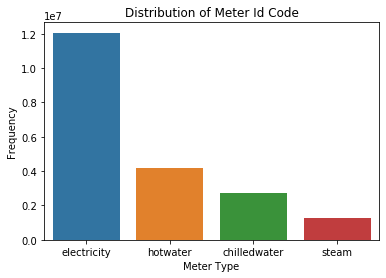

In [3]:
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
ax = sns.barplot(np.vectorize(meter_types.get)(pd.unique(train_df['meter'])), train_df['meter'].value_counts())
ax.set(xlabel='Meter Type', ylabel='Frequency', title='Distribution of Meter Id Code')
plt.show()

###### Remove buildings which have other than electricity meters

In [4]:
g = train_df[1:100000].groupby(['building_id','meter','timestamp']).filter(lambda x: x['meter'].sum() > 0)
d = g.building_id.unique()
train_df = train_df[~train_df['building_id'].isin(d)]
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


###### Filter only Electric Meter

In [5]:
train_df = train_df[train_df.meter == 0]
train_df['datetime'] = train_df['timestamp'].astype('datetime64[ns]') 
train_df['date'] = train_df['datetime'].apply(datetime.date)
train_df['time'] = train_df['datetime'].apply(datetime.time)
train_df.head()

,building_id,meter,timestamp,meter_reading,datetime,date,time
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00


###### Import Building Data

In [7]:
# Read 'building_metadata.csv' file
building_df = pd.read_csv('ashrae/building_metadata.csv')
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


Count NA values:

In [8]:
nan_cnt = building_df.isna().sum()
nan_cnt

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

No way to predict Year Built and Floor Count

In [9]:
building_df = building_df.drop(columns="floor_count")
building_df = building_df.drop(columns="year_built")

In [11]:
weather_df = pd.read_csv('ashrae/weather_train.csv')
#weather_df['datetime'] = pd.to_datetime(weather_df['timestamp'])
#weather_df['date'] = weather_df['datetime'].apply(datetime.date)
#weather_df['time'] = weather_df['datetime'].apply(datetime.time)

weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


###### Convert weather data to GMT, as those data were collected at there local time

In [12]:
weather_df_site0 = weather_df[weather_df.site_id == 0]
weather_df_site0['timestamp'] = pd.to_datetime(weather_df_site0['timestamp'])
weather_df_site0['timestamp'] = weather_df_site0['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site1 = weather_df[weather_df.site_id == 1]
weather_df_site1['timestamp'] = pd.to_datetime(weather_df_site1['timestamp'])
weather_df_site1['timestamp'] = weather_df_site1['timestamp'].dt.tz_localize('GMT').dt.tz_convert('Israel')

weather_df_site2 = weather_df[weather_df.site_id == 2]
weather_df_site2['timestamp'] = pd.to_datetime(weather_df_site2['timestamp'])
weather_df_site2['timestamp'] = weather_df_site2['timestamp'].dt.tz_localize('GMT').dt.tz_convert('MST')

weather_df_site3 = weather_df[weather_df.site_id == 3]
weather_df_site3['timestamp'] = pd.to_datetime(weather_df_site3['timestamp'])
weather_df_site3['timestamp'] = weather_df_site3['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site4 = weather_df[weather_df.site_id == 4]
weather_df_site4['timestamp'] = pd.to_datetime(weather_df_site4['timestamp'])
weather_df_site4['timestamp'] = weather_df_site4['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

weather_df_site5 = weather_df[weather_df.site_id == 5]
weather_df_site5['timestamp'] = pd.to_datetime(weather_df_site5['timestamp'])
weather_df_site5['timestamp'] = weather_df_site5['timestamp'].dt.tz_localize('GMT').dt.tz_convert('Israel')

weather_df_site6 = weather_df[weather_df.site_id == 6]
weather_df_site6['timestamp'] = pd.to_datetime(weather_df_site6['timestamp'])
weather_df_site6['timestamp'] = weather_df_site6['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site7 = weather_df[weather_df.site_id == 7]
weather_df_site7['timestamp'] = pd.to_datetime(weather_df_site7['timestamp'])
weather_df_site7['timestamp'] = weather_df_site7['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site8 = weather_df[weather_df.site_id == 8]
weather_df_site8['timestamp'] = pd.to_datetime(weather_df_site8['timestamp'])
weather_df_site8['timestamp'] = weather_df_site8['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site9 = weather_df[weather_df.site_id == 9]
weather_df_site9['timestamp'] = pd.to_datetime(weather_df_site9['timestamp'])
weather_df_site9['timestamp'] = weather_df_site9['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Central')

weather_df_site10 = weather_df[weather_df.site_id == 10]
weather_df_site10['timestamp'] = pd.to_datetime(weather_df_site10['timestamp'])
weather_df_site10['timestamp'] = weather_df_site10['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

weather_df_site11 = weather_df[weather_df.site_id == 11]
weather_df_site11['timestamp'] = pd.to_datetime(weather_df_site11['timestamp'])
weather_df_site11['timestamp'] = weather_df_site11['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site12 = weather_df[weather_df.site_id == 12]
weather_df_site12['timestamp'] = pd.to_datetime(weather_df_site12['timestamp'])
weather_df_site12['timestamp'] = weather_df_site12['timestamp'].dt.tz_localize('GMT').dt.tz_convert('Israel')

weather_df_site13 = weather_df[weather_df.site_id == 13]
weather_df_site13['timestamp'] = pd.to_datetime(weather_df_site13['timestamp'])
weather_df_site13['timestamp'] = weather_df_site13['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Central')

weather_df_site14 = weather_df[weather_df.site_id == 14]
weather_df_site14['timestamp'] = pd.to_datetime(weather_df_site14['timestamp'])
weather_df_site14['timestamp'] = weather_df_site14['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

weather_df_site15 = weather_df[weather_df.site_id == 15]
weather_df_site15['timestamp'] = pd.to_datetime(weather_df_site15['timestamp'])
weather_df_site15['timestamp'] = weather_df_site15['timestamp'].dt.tz_localize('GMT').dt.tz_convert('US/Eastern')

frames = [weather_df_site0, weather_df_site1, weather_df_site2, weather_df_site3, weather_df_site4, weather_df_site5, weather_df_site6, weather_df_site7, weather_df_site8, weather_df_site9, weather_df_site10, weather_df_site11, weather_df_site12, weather_df_site13, weather_df_site14, weather_df_site15]
weather_df_test = pd.concat(frames)

weather_df_test.head(50)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2015-12-31 19:00:00-05:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2015-12-31 20:00:00-05:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2015-12-31 21:00:00-05:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2015-12-31 22:00:00-05:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2015-12-31 23:00:00-05:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
5,0,2016-01-01 00:00:00-05:00,19.4,NaN,19.4,0.0,NaN,0.0,0.0
6,0,2016-01-01 01:00:00-05:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0
7,0,2016-01-01 02:00:00-05:00,21.1,NaN,21.1,0.0,1018.8,210.0,1.5
8,0,2016-01-01 03:00:00-05:00,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
9,0,2016-01-01 04:00:00-05:00,21.1,NaN,20.6,0.0,1019.0,290.0,1.5


In [13]:
weather_df_test['timestamp_2'] = weather_df_test['timestamp'].astype(str).str[:-6]
weather_df_test['timestamp_2'] = pd.to_datetime(weather_df_test['timestamp_2'])
weather_df_test['date'] = weather_df_test['timestamp_2'].apply(datetime.date)
weather_df_test['time'] = weather_df_test['timestamp_2'].apply(datetime.time)
weather_df = weather_df_test

weather_df.head()


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp_2,date,time
0,0,2015-12-31 19:00:00-05:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,2015-12-31 19:00:00,2015-12-31,19:00:00
1,0,2015-12-31 20:00:00-05:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,2015-12-31 20:00:00,2015-12-31,20:00:00
2,0,2015-12-31 21:00:00-05:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,2015-12-31 21:00:00,2015-12-31,21:00:00
3,0,2015-12-31 22:00:00-05:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,2015-12-31 22:00:00,2015-12-31,22:00:00
4,0,2015-12-31 23:00:00-05:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,2015-12-31 23:00:00,2015-12-31,23:00:00


###### Check NA values

In [18]:
weather_nan_cnt = weather_df.isna().sum()
weather_nan_cnt

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     6
sea_level_pressure    0
wind_direction        0
wind_speed            0
timestamp_2           0
date                  0
time                  0
dtype: int64

###### Fill NA values with the Median values by Date as the data was highly skewed, so taking Mean will not give proper Fit values

In [14]:
weather_df['air_temperature'] = weather_df['air_temperature'].fillna(weather_df.groupby('date')['air_temperature'].transform('median'))
weather_df['dew_temperature'] = weather_df['dew_temperature'].fillna(weather_df.groupby('date')['dew_temperature'].transform('median'))
weather_df['sea_level_pressure'] = weather_df['sea_level_pressure'].fillna(weather_df.groupby('date')['sea_level_pressure'].transform('median'))
weather_df['wind_speed'] = weather_df['wind_speed'].fillna(weather_df.groupby('date')['wind_speed'].transform('median'))
weather_df['cloud_coverage'] = weather_df['cloud_coverage'].fillna(weather_df.groupby('date')['cloud_coverage'].transform('median'))
weather_df['precip_depth_1_hr'] = weather_df['precip_depth_1_hr'].fillna(weather_df.groupby('date')['precip_depth_1_hr'].transform('median'))
weather_df['wind_direction'] = weather_df['wind_direction'].fillna(weather_df.groupby('date')['wind_direction'].transform('median'))

##### Custom function to reduce Memory Size

In [15]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [19]:
train_df, myList = reduce_mem_usage(train_df)

Memory usage of properties dataframe is : 460.52874755859375  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  0
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  30268.0
dtype after:  float32
******************************
******************************
Column:  datetime
dtype before:  datetime64[ns]
min for this col:  2016-01-01 00:00:00
max for this col:  2016-12-31 23:00:00


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [20]:
building_df, myList = reduce_mem_usage(building_df)

Memory usage of properties dataframe is : 0.0442962646484375  MB
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this col:  875000
dtype after:  uint32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.020804405212402344  MB
This is  46.96650017223562 % of the initial size


In [21]:
weather_df, myList = reduce_mem_usage(weather_df)

Memory usage of properties dataframe is : 13.862983703613281  MB
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  air_temperature
dtype before:  float64
min for this col:  -28.9
max for this col:  47.2
dtype after:  float32
******************************
******************************
Column:  cloud_coverage
dtype before:  float64
min for this col:  0.0
max for this col:  9.0
dtype after:  float32
******************************
******************************
Column:  dew_temperature
dtype before:  float64
min for this col:  -35.0
max for this col:  26.1
dtype after:  float32
******************************
******************************
Column:  precip_depth_1_hr
dtype before:  float64
min for this col:  -1.0
max for this col:  343.0
dtype after:  int16
******************************
******************************
Column:  sea_level_pr

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

##### Merging 3 Dataframe into a Single One

In [22]:
merge_df_1 = train_df.merge(building_df, on='building_id', how='inner')

In [24]:
merge_df_1 = merge_df_1.merge(weather_df, on=['site_id','date','time'], how='inner')

In [25]:
merge_df_1.head()

,building_id,meter,timestamp_x,meter_reading,datetime,date,time,site_id,primary_use,square_feet,timestamp_y,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp_2
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,7432,2016-01-01 00:00:00-05:00,19.4,0.0,19.4,0,1019.150024,0,0.0,2016-01-01
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,2720,2016-01-01 00:00:00-05:00,19.4,0.0,19.4,0,1019.150024,0,0.0,2016-01-01
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,5376,2016-01-01 00:00:00-05:00,19.4,0.0,19.4,0,1019.150024,0,0.0,2016-01-01
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,23685,2016-01-01 00:00:00-05:00,19.4,0.0,19.4,0,1019.150024,0,0.0,2016-01-01
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,2016-01-01,00:00:00,0,Education,116607,2016-01-01 00:00:00-05:00,19.4,0.0,19.4,0,1019.150024,0,0.0,2016-01-01


In [39]:
merge_df_1 = merge_df_1.drop(columns="timestamp_x")
merge_df_1 = merge_df_1.drop(columns="timestamp_y")
merge_df_1 = merge_df_1.drop(columns="timestamp_2")

###### Drop meter column, as all are electricity (0) meters

In [29]:
merge_df_1 = merge_df_1.drop(columns="meter")

##### Check Correlation

In [30]:
corr_matrix_train = merge_df_1.corr()
corr_matrix_train

,building_id,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
building_id,1.000000,-0.112658,0.962435,-0.054677,-0.241017,-0.029817,-0.162644,-0.010513,-0.037687,0.034461,0.041595
meter_reading,-0.112658,1.000000,-0.105226,0.550374,0.100445,0.017823,0.083660,0.007934,0.000133,-0.018434,-0.026595
site_id,0.962435,-0.105226,1.000000,-0.057821,-0.215876,0.010115,-0.158634,-0.005031,-0.053765,0.019109,0.034422
square_feet,-0.054677,0.550374,-0.057821,1.000000,0.017528,0.009479,-0.003473,-0.000864,-0.006132,-0.003167,-0.016777
air_temperature,-0.241017,0.100445,-0.215876,0.017528,1.000000,0.090252,0.805455,0.019321,-0.214933,-0.103962,-0.070540
cloud_coverage,-0.029817,0.017823,0.010115,0.009479,0.090252,1.000000,0.121965,0.016451,-0.067270,-0.006880,0.091115
dew_temperature,-0.162644,0.083660,-0.158634,-0.003473,0.805455,0.121965,1.000000,0.066793,-0.196347,-0.175095,-0.143013
precip_depth_1_hr,-0.010513,0.007934,-0.005031,-0.000864,0.019321,0.016451,0.066793,1.000000,-0.049817,-0.016354,0.019088
sea_level_pressure,-0.037687,0.000133,-0.053765,-0.006132,-0.214933,-0.067270,-0.196347,-0.049817,1.000000,-0.117524,-0.212363
wind_direction,0.034461,-0.018434,0.019109,-0.003167,-0.103962,-0.006880,-0.175095,-0.016354,-0.117524,1.000000,0.361471


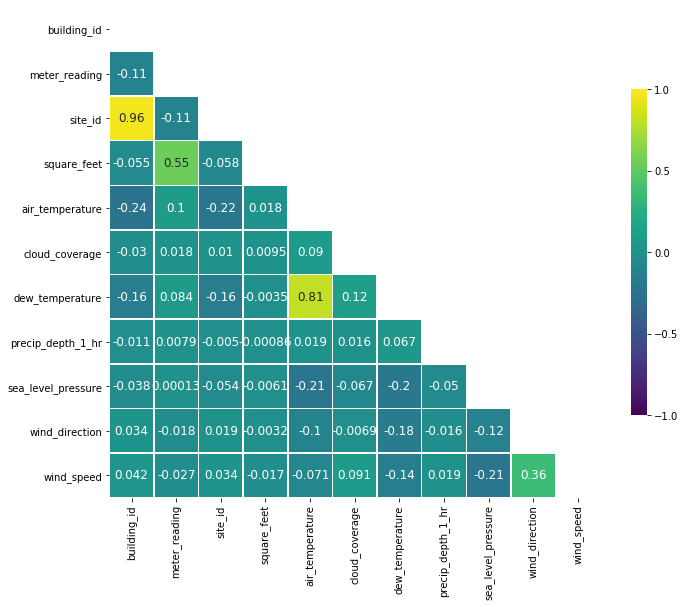

In [31]:
mask = np.zeros_like(corr_matrix_train, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix_train, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix_train.columns, rotation = 0)
ax.set_xticklabels(corr_matrix_train.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

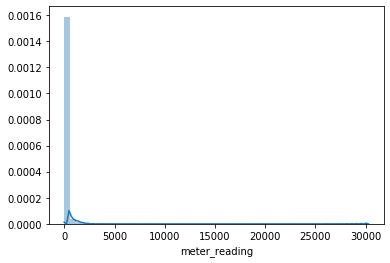

In [32]:
sns.distplot(merge_df_1['meter_reading'])
plt.show()

##### Filter Outliers

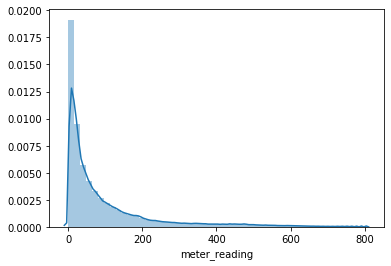

In [35]:
merge_df_1 = merge_df_1[merge_df_1['meter_reading']<=800]
sns.distplot(merge_df_1['meter_reading'])
plt.show()

In [40]:
merge_df_1.shape

(7315947, 15)

## Model 1

In [41]:
model_df_1 = pd.get_dummies(merge_df_1, columns=['primary_use'])

In [45]:
features_cols = ['building_id',  'site_id', 'square_feet',
       'air_temperature',  'dew_temperature', 
        'sea_level_pressure', 
       'wind_speed', 'primary_use_Education',
       'primary_use_Entertainment/public assembly', 'primary_use_Healthcare',
       'primary_use_Lodging/residential', 'precip_depth_1_hr', 'cloud_coverage', 'wind_direction',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services', 
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage']
x = model_df_1[features_cols]
y = model_df_1[['meter_reading']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


model = LinearRegression()
model.fit(X_train, y_train)
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error') #, return_train_score=True
print ("Cross-validated scores:", np.sqrt(abs(scores)))

coefficient of determination: 0.27752294795111343
intercept: [91.85784002]
slope: [[-4.80201322e+01  4.48777579e+01  6.76576815e+01  6.88380973e+00
   7.05064691e+00  3.47959269e+00 -1.23772242e+00  1.26713866e+13
   9.35861524e+12  2.42501529e+12  7.65240463e+12  8.58271164e-01
  -9.93242176e-01  5.30206632e-01  2.38686932e+12  9.58180107e+12
   4.10616915e+12  3.99409593e+12  9.47405463e+12  1.29353038e+12
   2.79616085e+12  2.57974402e+12  1.83536398e+12  9.13634099e+11
   3.12451862e+12]]
MAE: 72.88160793148809
MSE: 12537.30368198605
RMSE: 111.97010173249843
Cross-validated scores: [184.29315407 142.92812277  92.48545232  93.80193173  89.40582473
 133.50402957  89.96200376  85.10229434 105.89500374 144.48788584]


## Model 2

In [51]:

merge_df_by_month = merge_df_1.copy()
merge_df_by_month['month']=pd.to_datetime(merge_df_by_month['datetime']).dt.month
merge_df_by_month['year']=pd.to_datetime(merge_df_by_month['datetime']).dt.year
merge_df_by_month = merge_df_by_month.groupby([merge_df_by_month.building_id, merge_df_by_month.month, merge_df_by_month.year]).agg({'meter_reading':sum, 'air_temperature': "mean", 'cloud_coverage': "mean", 'dew_temperature':"mean", 'precip_depth_1_hr': "mean", 'sea_level_pressure':"mean", 'wind_direction': "mean", 'wind_speed':"mean", 'building_id': 'first' , 'month': 'first' , 'year': 'first' , 'primary_use': 'first' , 'site_id': 'first', 'square_feet': 'first'  })
merge_df_by_month

meter_reading  air_temperature  cloud_coverage  \
building_id month year                                                   
0           1     2016     133.781799        14.642339        1.985215   
            2     2016       0.000000        16.139656        1.913793   
            3     2016       0.000000        21.313593        1.913863   
            4     2016      59.382702        22.423471        2.244444   
            5     2016   58056.769531        24.726881        2.346774   
            6     2016  182240.875000        27.374584        2.566667   
            7     2016  207976.781250        28.571640        2.676075   
            8     2016  211510.406250        27.592607        2.776882   
            9     2016  175311.531250        26.870138        2.481945   
            10    2016  174630.328125        24.030376        2.056452   
            11    2016  141980.046875        20.044382        1.649792   
            12    2016  133833.015625        19.954533        2.311231   
1           1     2016     327.901794        14.642339        1.985215   
            2     2016     535.127319        16.139656        1.913793   
            3     2016     711.773804        21.313593        1.913863   
            4     2016     889.512512        22.423471        2.244444   
            5     2016   33666.871094        24.726881        2.346774   
            6     2016   96898.156250        27.374584        2.566667   
            7     2016  100586.195312        28.571640        2.676075   
            8     2016  100991.351562        27.592607        2.776882   
            9     2016   97497.195312        26.870138        2.481945   
            10    2016   89028.507812        24.030376        2.056452   
            11    2016   64024.695312        20.044382        1.649792   
            12    2016   72280.671875        19.954533        2.311231   
2           1     2016       4.095300        14.642339        1.985215   
            2     2016       0.000000        16.139656        1.913793   
            3     2016       0.000000        21.313593        1.913863   
            4     2016       0.000000        22.423471        2.244444   
            5     2016    4970.404785        24.726881        2.346774   
            6     2016   16376.530273        27.374584        2.566667   
...                               ...              ...             ...   
1446        7     2016    1898.675049        21.844553        1.563547   
            8     2016    2495.425049        22.309275        1.805797   
            9     2016    3574.975098        17.263195        1.216833   
            10    2016    3218.308350        10.819107        1.037657   
            11    2016    2912.508301         5.362500        0.625000   
            12    2016    1333.074951        -2.141994        1.689543   
1447        1     2016  113497.171875        -3.358939        0.898485   
            2     2016   47239.699219         1.266667        1.382222   
            3     2016    8710.049805         8.968085        1.021277   
            4     2016  143170.203125         5.325601        1.152758   
            5     2016  139569.640625        13.434759        1.107586   
            6     2016  111382.148438        18.546568        1.398507   
            7     2016  123974.445312        21.844553        1.563547   
            8     2016  124724.023438        22.309275        1.805797   
            9     2016  142241.296875        17.263195        1.216833   
            10    2016  142746.437500        10.819107        1.037657   
            11    2016  141678.171875         5.374111        0.625889   
            12    2016  106667.203125        -2.141994        1.689543   
1448        1     2016    2514.824951        -3.358939        0.898485   
            2     2016     793.775024         1.266667        1.382222   
            3     2016     174.125000         8.968085        1.021277   
            4     2016    23

In [52]:
merge_df_by_month.month.value_counts()

5     866
11    866
10    866
12    863
4     863
3     863
1     862
9     861
2     860
8     860
7     858
6     858
Name: month, dtype: int64

In [53]:
merge_df_by_month = pd.get_dummies(merge_df_by_month, columns=['month'])
merge_df_by_month = pd.get_dummies(merge_df_by_month, columns=['primary_use'])

In [54]:
features_cols = ['building_id',  'site_id', 'square_feet',
       'air_temperature',  'dew_temperature', 
        'sea_level_pressure', 'precip_depth_1_hr', 'cloud_coverage', 'wind_direction',
       'wind_speed', 'primary_use_Education',
       'primary_use_Entertainment/public assembly', 'primary_use_Healthcare',
       'primary_use_Lodging/residential', 
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'] 
x = merge_df_by_month[features_cols]
y = merge_df_by_month[['meter_reading']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


model = LinearRegression()
model.fit(X_train, y_train)
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error') #, return_train_score=True
print ("Cross-validated scores:", np.sqrt(abs(scores)))

coefficient of determination: 0.2456389438636446
intercept: [64930.82788061]
slope: [[-3.83183452e+04  3.09447897e+04  3.78346068e+04 -1.70081106e+04
   1.12494021e+04 -6.60459352e+03  6.72980659e+03 -4.01800866e+02
  -3.22058395e+02 -8.72658942e+03 -7.20806924e+15 -5.32570902e+15
  -1.43232975e+15 -4.31714042e+15 -1.35490476e+15 -5.44189834e+15
  -2.30161073e+15 -2.22223542e+15 -5.35266182e+15 -7.50507354e+14
  -1.62332248e+15 -1.46421480e+15 -1.01513620e+15 -5.00684419e+14
  -1.81013174e+15  5.08693501e+15  4.99133587e+15  4.98357416e+15
   5.10199215e+15  5.03754863e+15  5.12445756e+15  5.07938217e+15
   5.06802237e+15  5.08693501e+15  5.07938217e+15  5.10199215e+15
   4.90896679e+15]]
MAE: 50162.629484753765
MSE: 5712643938.612288
RMSE: 75582.03449638207
Cross-validated scores: [121133.2232186   91688.7898797   67304.84878798  49939.35869317
  65581.6976493   99221.73406227  68959.29074456  64241.05524054
  74937.73225125  96616.97444205]


In [58]:
features_cols = ['building_id',  'site_id', 'square_feet',
       'air_temperature',  'dew_temperature', 
        'sea_level_pressure', 'precip_depth_1_hr', 'cloud_coverage', 'wind_direction',
       'wind_speed', 'primary_use_Education',
       'primary_use_Entertainment/public assembly', 'primary_use_Healthcare',
       'primary_use_Lodging/residential', 
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'] 
x = merge_df_by_month[features_cols]
y = merge_df_by_month[['meter_reading']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3) # 70% training and 30% test

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


lr = LinearRegression()
lr.fit(X_train, y_train)

rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(X_train, y_train)
train_score=lr.score(X_train, y_train)
test_score=lr.score(X_test, y_test)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_test, y_test)
print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", Ridge_train_score)
print ("ridge regression test score low alpha:", Ridge_test_score)
print ("ridge regression train score high alpha:", Ridge_train_score100)
print ("ridge regression test score high alpha:", Ridge_test_score100)


lasso = Lasso()
lasso.fit(X_train,y_train)
lasso_train_score=lasso.score(X_train,y_train)
lasso_test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("Lasso training score:", lasso_train_score) 
print ("Lasso test score: ", lasso_test_score)
print ("number of features used: ", coeff_used)
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("Lasso training score for alpha=0.01:", train_score001 )
print ("Lasso test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)





linear regression train score: 0.26116085336706907
linear regression test score: 0.26692659751941883
ridge regression train score low alpha: 0.261160722469177
ridge regression test score low alpha: 0.2669410151518872
ridge regression train score high alpha: 0.2596123354193046
ridge regression test score high alpha: 0.2688448830124782
Lasso training score: 0.2611606980448963
Lasso test score:  0.266953008313367
number of features used:  36
Lasso training score for alpha=0.01: 0.2611607225036302
Lasso test score for alpha =0.01:  0.2669405414882272
number of features used: for alpha =0.01: 36
